In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
import os
import pandas as pd
from scipy.optimize import linear_sum_assignment
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, pairwise_distances
import time


plt.style.use('ggplot')
start = time.time()

In [111]:
def mv_weighted(values, weights):
    # Normalize weight
    weights = weights/sum(weights)
    mean = values.multiply(weights, axis=0).sum()
    variance = ((values-mean)**2).multiply(weights, axis=0).sum()
    return mean, variance

def calculate_smd(covariates, treatment, weights=None):
    c_control = covariates.loc[(treatment == 0), :]
    c_treatment = covariates.loc[(treatment == 1), :]
    if weights is not None:
        m_control, v_control = mv_weighted(c_control, weights[(treatment == 0)])
        m_treatment, v_treatment = mv_weighted(c_treatment, weights[(treatment == 1)])
    else:
        m_control, v_control = c_control.mean(), c_control.var()
        m_treatment, v_treatment = c_treatment.mean(), c_treatment.var()
    num = m_treatment - m_control
    denom = np.sqrt((v_treatment + v_control)/2)
    return np.abs(num/denom)

def plot_smd(ax, smds, title='Comparison of SMDs'):
    x = np.arange(smds.shape[0])
    width = 0.4

    rects1 = ax.barh(x + width/2, smds['Before'], width, alpha=0.8, label='Before')
    rects2 = ax.barh(x - width/2, smds['After'], width, alpha=0.8, label='After')

    ax.grid(False)
    ax.set_yticks(x)
    ax.set_yticklabels(smds.index.to_list())
    ax.legend()
    ax.vlines(0.1, 0, x.max()+1, linestyles='--', alpha=0.6)
    ax.set_title(title);

def compare_smds(smds):
    # Mean SMD
    for i, x in smds.mean().to_dict().items():
        print(f'SMD {i}\t: {x:.4f}')

    # SMD plot by feature
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    fig.set_dpi(200)
    plt.subplots_adjust(wspace=0.3)

    plot_smd(ax[0], smds.tail(int(smds.shape[0]/2)), 'Comparison of SMDs (1)')
    plot_smd(ax[1], smds.head(int(smds.shape[0]/2)), 'Comparison of SMDs (2)')

def greedy_pair(distances, maxpair=1000, caliper=6):
    foo = distances.copy()
    mdist = foo.max()

    pairs = []
    for _ in range(maxpair):
        pair = (foo.argmin()//foo.shape[1], foo.argmin()%foo.shape[1])
        pairs.append([pair, foo[pair]])
        if distances[pair] > caliper:
            break
        foo[pair[0], :] = mdist
        foo[:, pair[1]] = mdist

    return pairs

# Get Data

In [3]:
if os.path.exists('raw.csv'):
    df = pd.read_csv('raw.csv', index_col=0)
else:
    url = "http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/rhc.csv"
    df = pd.read_csv(url, index_col=0)

# Data Processing

In [4]:
# I prefer seeing numbers
df = df.replace('No', 0).replace('Yes', 1)

# WTF is a 'swang', it is 'treatment'
df.rename(columns={'swang1': 'rhc'}, inplace=True)

# Dates are irrelevant, drop
df.drop(columns=['sadmdte', 'dschdte', 'dthdte', 'lstctdte'], inplace=True)

# ID is irrelevant
df.drop(columns=['ptid'], inplace=True)

## Extract Diseases

In [5]:
# Print possible diseases
diseases = [x for x in set(list(df['cat1'].unique())+list(df['cat2'].unique())) if str(x) != 'nan']
print('Possible diseases:', diseases)

# Extract indicator of MOSF or coma
df['mosf'] = [(('MOSF' in str(x)) or ('MOSF' in str(y))) for x, y in zip(df['cat1'], df['cat2'])]
df['coma'] = [(('Coma' in str(x)) or ('Coma' in str(y))) for x, y in zip(df['cat1'], df['cat2'])]

# Drop after extraction of primary/secondary diseases
df.drop(columns=['cat1', 'cat2'], inplace=True)

Possible diseases: ['MOSF w/Sepsis', 'Lung Cancer', 'ARF', 'Colon Cancer', 'Coma', 'MOSF w/Malignancy', 'COPD', 'CHF', 'Cirrhosis']


## Extract Insurance

In [6]:
print('Insurances :', df['ninsclas'].unique())

# Extract insurance types
df['medicare'] = [('Medicare' in str(x)) for x in df['ninsclas']]
df['medicaid'] = [('Medicaid' in str(x)) for x in df['ninsclas']]
df['private'] = [('Private' in str(x)) for x in df['ninsclas']]

# Drop after extraction of insurance type
df.drop(columns=['ninsclas'], inplace=True)

Insurances : ['Medicare' 'Private & Medicare' 'Private' 'Medicaid' 'No insurance'
 'Medicare & Medicaid']


## Drop Columns with High Unavailability

In [7]:
nullcount = df.isnull().sum()
print('Null count')
for i, x in nullcount[nullcount > 0].to_dict().items():
    print(f'{i}\t: {x}/{df.shape[0]}')

# Drop due to high data unavailability
df.drop(columns=['adld3p', 'urin1'], inplace=True)

Null count
adld3p	: 4296/5735
urin1	: 3028/5735


## Map to Numeric/Ordinal

In [8]:
# What's left?
dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'bool']
foo = df.select_dtypes(exclude=dtypes)
foo.head(5)

,ca,sex,rhc,race,income
1,1,Male,No RHC,white,Under $11k
2,0,Female,RHC,white,Under $11k
3,1,Female,RHC,white,$25-$50k
4,0,Female,No RHC,white,$11-$25k
5,0,Male,RHC,white,Under $11k


In [9]:
print('Unique values')
for i, col in foo.items():
    print(f'{i}\t: {col.nunique()} {col.unique()}')

Unique values
ca	: 3 [1 0 'Metastatic']
sex	: 2 ['Male' 'Female']
rhc	: 2 ['No RHC' 'RHC']
race	: 3 ['white' 'black' 'other']
income	: 4 ['Under $11k' '$25-$50k' '$11-$25k' '> $50k']


That's... manageable

In [10]:
maps = {}

maps['ca'] = {1: 'yes', 0: 'no', 'Metastatic': 'ms'}
maps['sex'] = {'Male': 0, 'Female': 1}
maps['rhc'] = {'No RHC': 0, 'RHC': 1}
maps['income'] = {x: y for x, y in zip(['Under $11k', '$11-$25k', '$25-$50k', '> $50k'],
                                       ['low', 'midlow', 'midhigh', 'high'])}

# Map
for i, m in maps.items():
    df[i] = [m[x] for x in df[i]]

## Categoricals

In [11]:
# What's left? - pt. 2
dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'bool']
foo = df.select_dtypes(exclude=dtypes)
foo.head(5)

,ca,race,income
1,yes,white,low
2,no,white,low
3,yes,white,midhigh
4,no,white,midlow
5,no,white,low


In [12]:
categoricals = ['ca', 'race', 'income']

cats = df.loc[:, categoricals]
cats = pd.get_dummies(cats, prefix_sep='-')

clean = df.drop(columns=categoricals)
clean = pd.concat([clean, cats], axis=1)

## Important Fields

In [13]:
result = clean['death'].values
treatment = clean['rhc'].values
covariates = clean.drop(columns=['death', 'rhc'])

# Analysis - IPTW

## Propensity
Estimate with Logistic regression

In [14]:
lr = LogisticRegression(penalty='none', solver='newton-cg')
lr.fit(covariates, treatment)

# Get propensity scores
propensity = lr.predict_proba(covariates)[:, 1]

print(f'Confounding fit on treatment: {100*accuracy_score(treatment, lr.predict(covariates)):.2f}%')
print(f'Mean propensity to treatment fraction ratio: {propensity.mean()/treatment.mean():.4f}')

Confounding fit on treatment: 73.01%
Mean propensity to treatment fraction ratio: 1.0000


Check positivity assumption by looking at the propensity distribution.

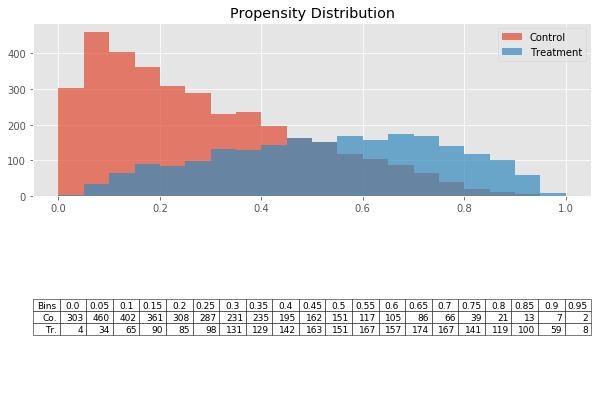

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(10,7))

blist = [x/20 for x in range(21)]
ax[0].hist(propensity[(treatment == 0)], bins=blist, alpha=0.7, label='Control')
ax[0].hist(propensity[(treatment == 1)], bins=blist, alpha=0.7, label='Treatment')
ax[0].legend()
ax[0].set_title('Propensity Distribution')

bincount = pd.DataFrame([np.histogram(propensity[(treatment == 0)], blist)[0],
                         np.histogram(propensity[(treatment == 1)], blist)[0]],
                        index=['Co.', 'Tr.']).reset_index()
bincount.columns = [x for x in range(21)]
cell_text = []
for row in range(len(bincount)):
    cell_text.append(bincount.iloc[row])

ax[1].axis('off')
ax[1].table(cellText=cell_text, colLabels=['Bins']+blist[:-1], loc='center');

Looks like the bin 0-0.05 has a terrible imbalance. Can try truncation.

## IPTW Weighting
Inverse Probability of Treatment

In [16]:
weights = 1/np.abs((1-treatment) - propensity)

pseudo_pop = sum(weights)
pp_treated = sum(weights*treatment)
print(f'Fraction of treated pseudo-population: {100*pp_treated/pseudo_pop:.2f}%')

Fraction of treated pseudo-population: 49.06%


## Covariate Balance
Before and after IPTW. Let's hope it is under 0.1

SMD Before	: 0.1475
SMD After	: 0.0148


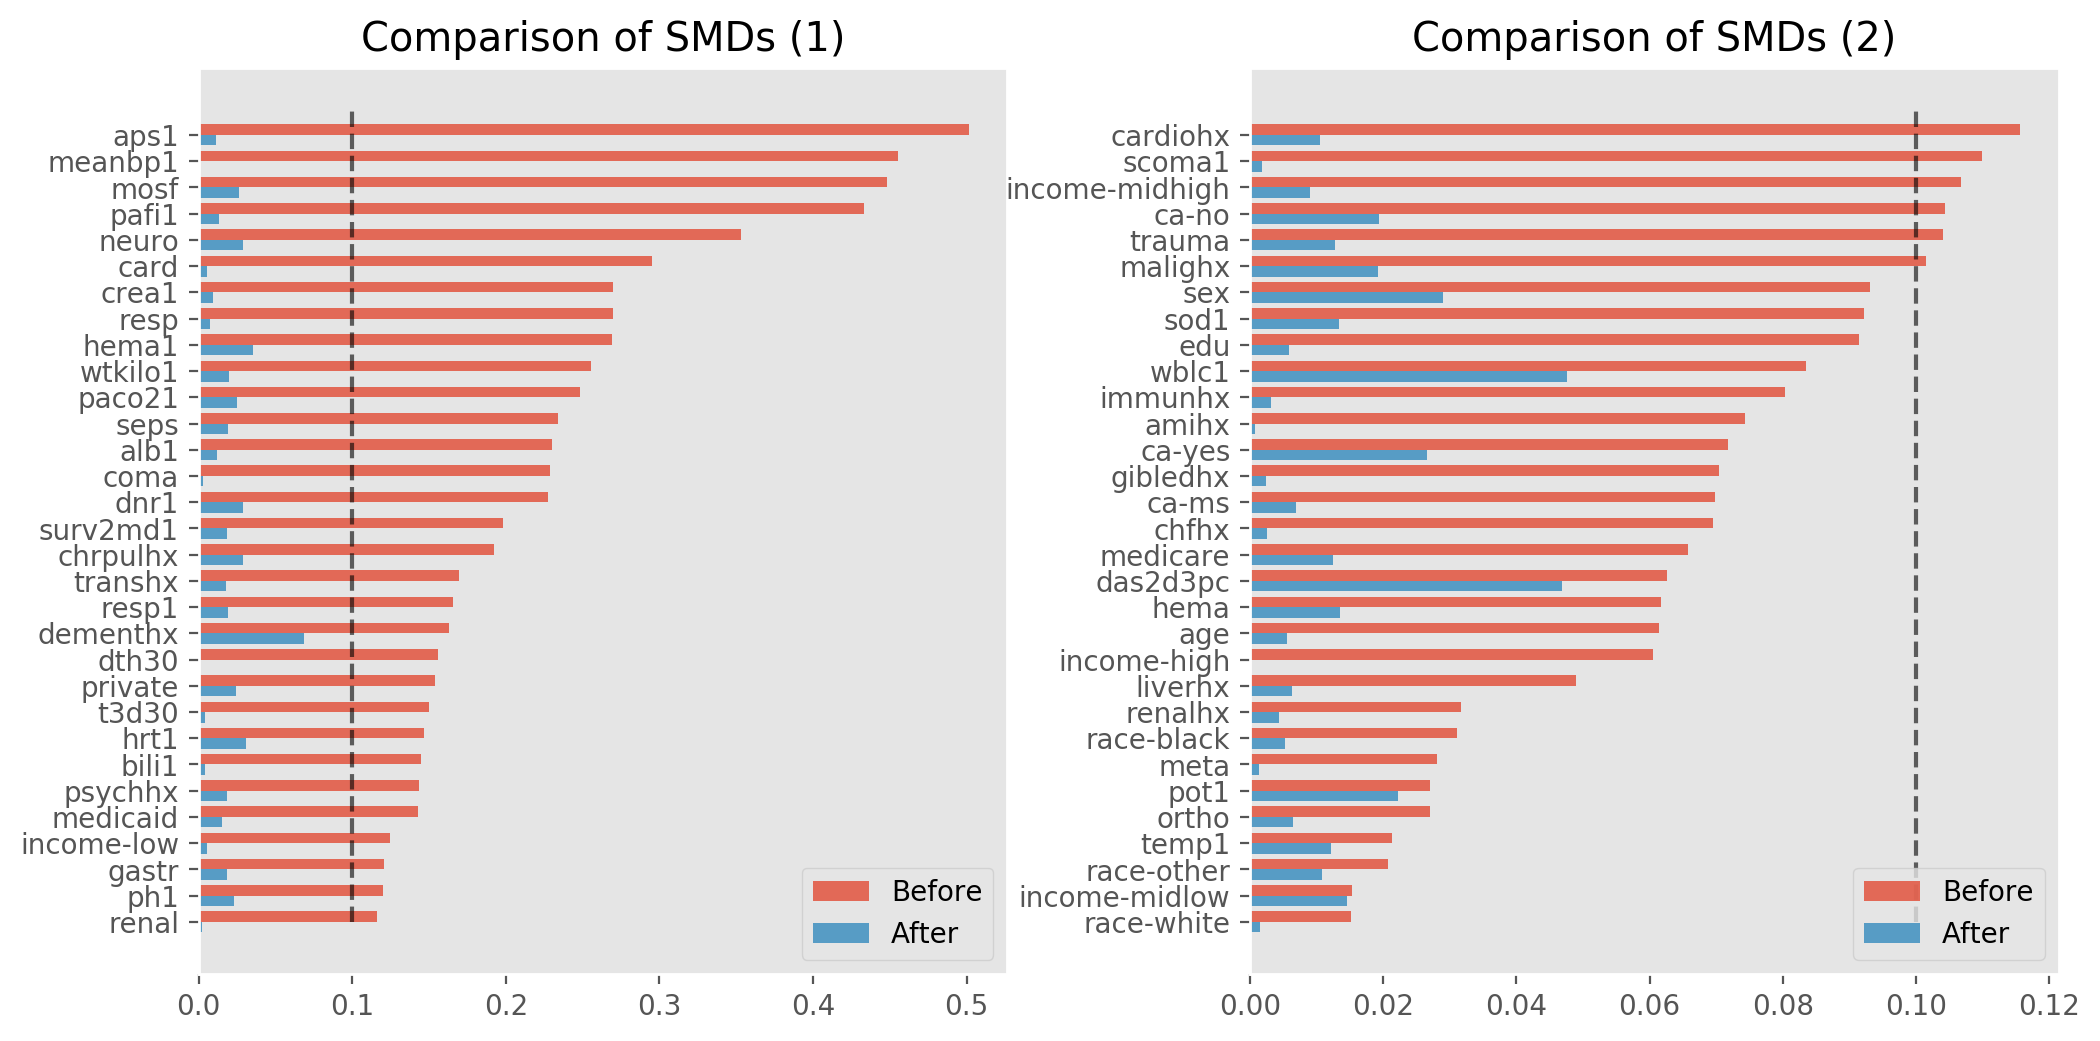

In [117]:
smds = pd.DataFrame(
    [calculate_smd(covariates, treatment),
     calculate_smd(covariates, treatment, weights)],
    index=['Before', 'After']
).T.sort_values('Before')

compare_smds(smds)

Solved!

## Results in Pseudo-Population
Use Logit link function for for the generalized linear model, as the response is in [0,1].

In [18]:
# Death rate in each sub-pseudo-population
p0 = sum(weights[(treatment == 0)]*result[(treatment == 0)])/sum(weights[(treatment == 0)])
p1 = sum(weights[(treatment == 1)]*result[(treatment == 1)])/sum(weights[(treatment == 1)])

# Log causal odds ratio
print(f'Treatment Effect (Calculated): {(p1/(1-p1))/(p0/(1-p0)):.4f}')

Treatment Effect (Calculated): 1.1603


In [19]:
def get_effect(classifier, treatment, result, weights):
    classifier.fit(treatment.reshape(-1,1), result, sample_weight=weights)
    return np.exp(classifier.coef_[0][0])

# Fit classifier with weighted samples
classifier = LogisticRegression()

# Solver result
print(f'Treatment Effect (Solver): {get_effect(classifier, result, treatment, weights):.4f}')

Treatment Effect (Solver): 1.1600


In [20]:
samples = 10000
repeat = 100
effects = []

for _ in range(repeat):
    indexes = choice(len(treatment), samples)
    effect = get_effect(LogisticRegression(), treatment[indexes], result[indexes], weights[indexes])
    effects.append(effect)

print(f'Treatment Effect (Bootstrap): {np.mean(effects):.4f} ({np.std(effects):.4f})')

Treatment Effect (Bootstrap): 1.1580 (0.0661)


Generally the treatment increases risk of death by 16%

# Analysis - Matching
Match by closest Mahalanobis distance

## Control-Treatment Paired Distances

In [92]:
i_control = np.argwhere(treatment == 0).ravel()
i_treatment = np.argwhere(treatment == 1).ravel()

distances = pairwise_distances(covariates, metric='mahalanobis', n_jobs=-1)
distances = distances[np.ix_(i_control, i_treatment)]

## Hungarian Algorithm Pairing
Use Hungarian Algorithm for pair assignments minimized for total distance

SMD Before	: 0.1475
SMD After	: 0.1269


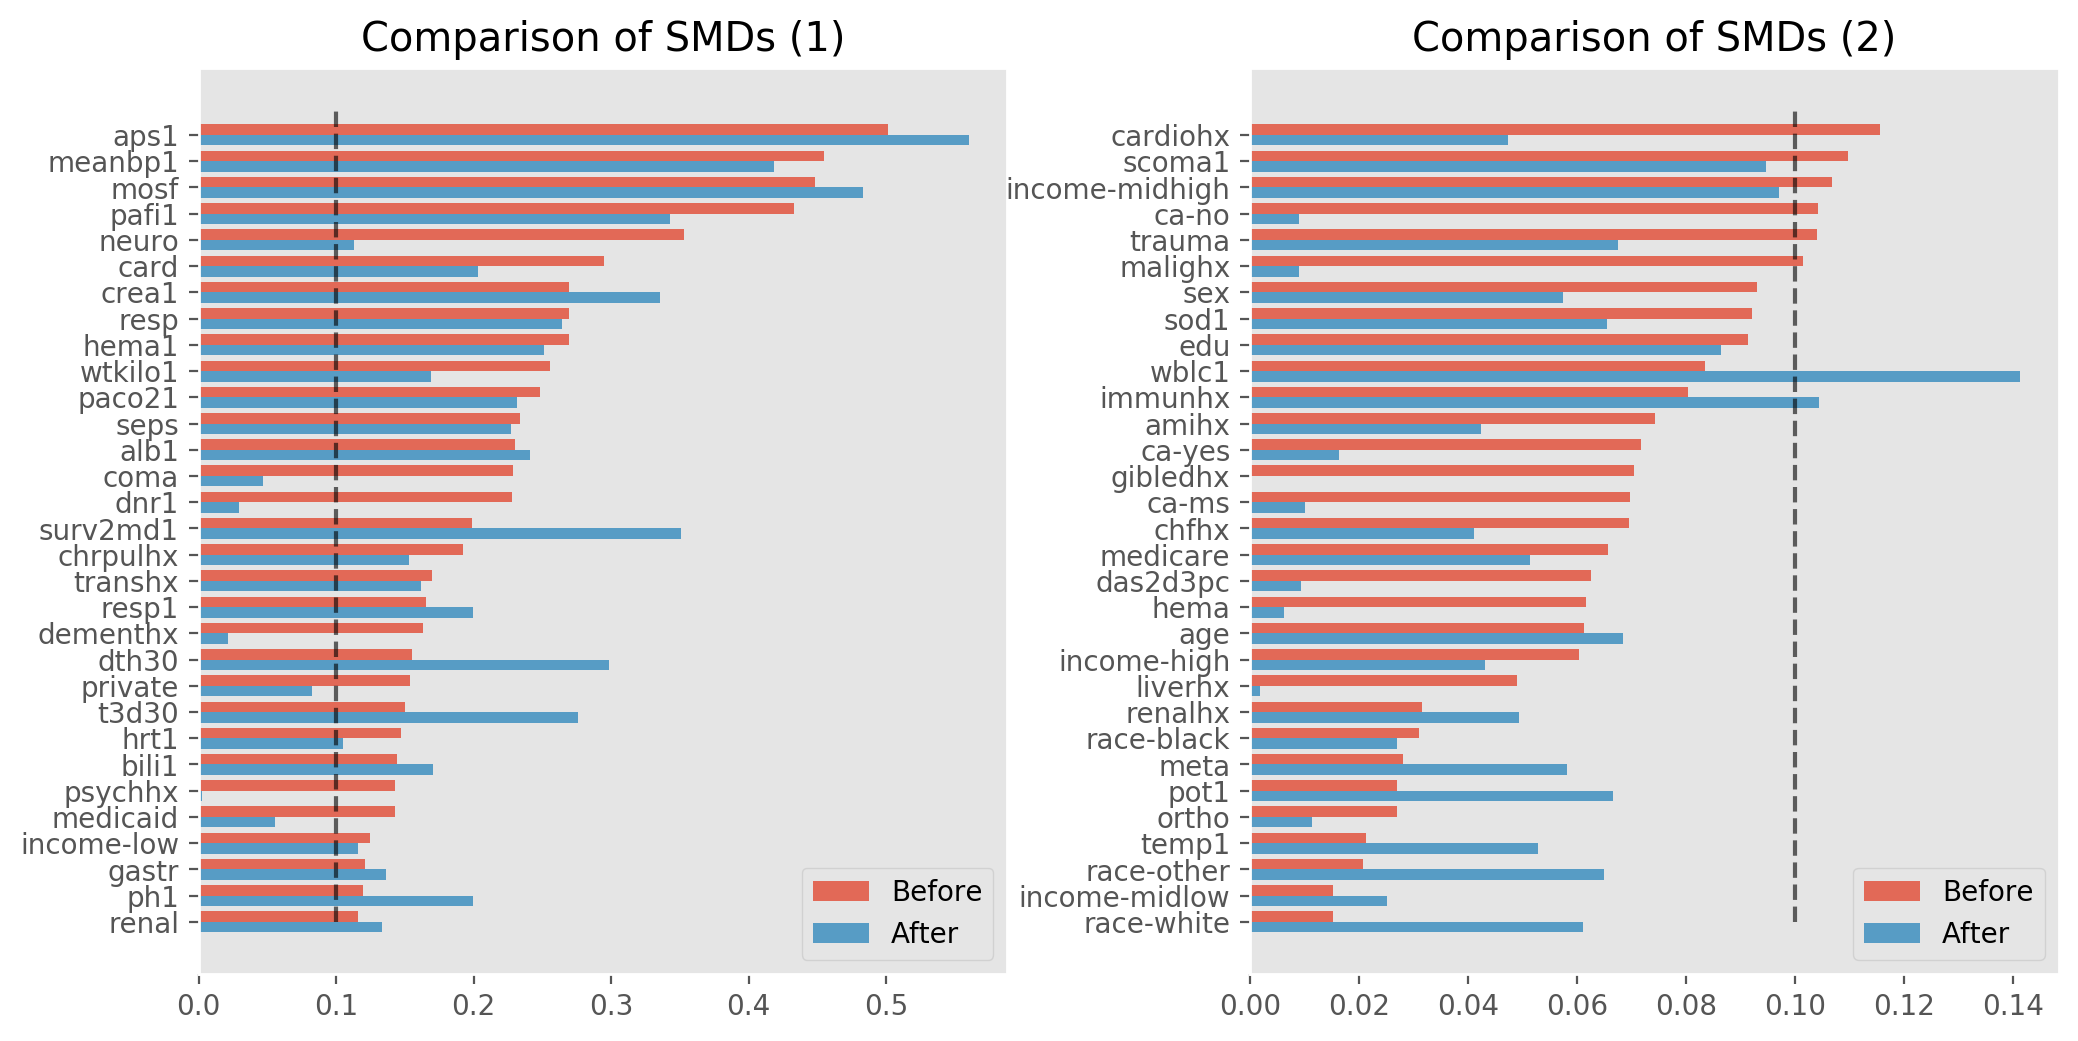

In [136]:
assignment = linear_sum_assignment(distances.T)
# Indexes in each sub-population (Note that the distance matrix is transposed)
ps = [(y, x) for x, y in zip(*assignment)]
# Indexes in original data
ids = [i_control[x[0]] for x in ps]+[i_treatment[x[1]] for x in ps]

smds = pd.DataFrame(
    [calculate_smd(covariates, treatment),
     calculate_smd(covariates.iloc[ids, :], treatment[ids])],
    index=['Before', 'After']
).T.sort_values('Before')

compare_smds(smds)

That is **terrible**, let's specify a caliper.

## Greedy Pairing
Greedy pairing on global lowest distance.

In [114]:
# Hyperparameter: Control caliper strictness in a SMD+speed vs sample size tradeoff (value > 1)
caliper_strictness = 10

SMD Before	: 0.1475
SMD After	: 0.0710


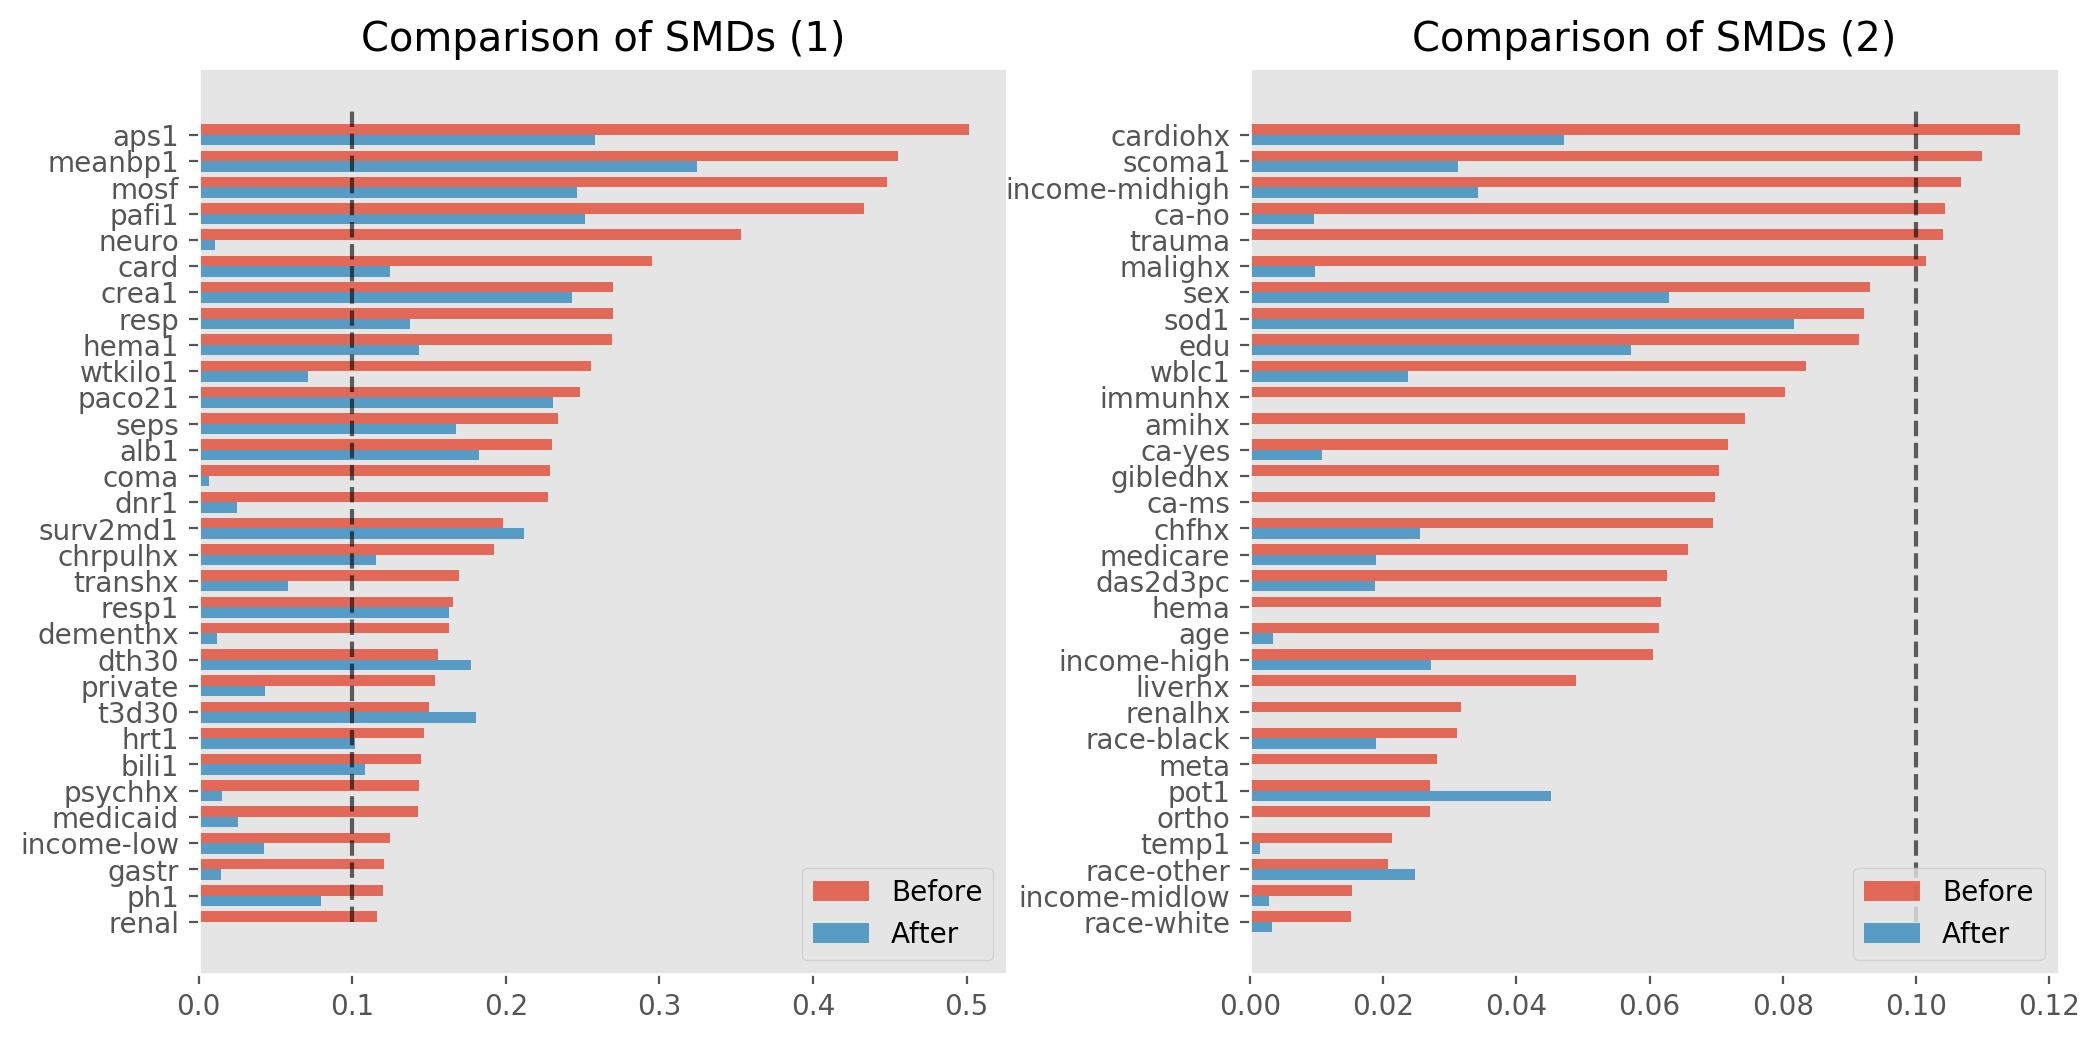

In [115]:
pairs = greedy_pair(distances, caliper=covariates.shape[1]/caliper_strictness)
# Indexes in each sub-population
ps = [x[0] for x in pairs]
# Indexes in original data
ids = [i_control[x[0]] for x in ps]+[i_treatment[x[1]] for x in ps]

smds = pd.DataFrame(
    [calculate_smd(covariates, treatment),
     calculate_smd(covariates.iloc[ids, :], treatment[ids])],
    index=['Before', 'After']
).T.sort_values('Before')

compare_smds(smds)

Better but not much better. Anyway, it is not fit for modeling.

In [21]:
end = time.time()
print(f'Elapsed: {round(end-start, 2)}s')

Elapsed: 3.02s
